dedispersing CHIME1 by -0.01859999999999218 pc/cm^3
finding fit CHIME1...
solution nlsq: [  41.74851558   40.46235013 1023.40501795  176.24653795    2.20077067
    1.57187798]
dedispersing CHIME2 by -0.01859999999999218 pc/cm^3
finding fit CHIME2...
solution nlsq: [  36.15779289   68.39360871 1002.5122487   355.78768451    1.37681316
    1.57194437]
dedispersing B1 by -0.01859999999999218 pc/cm^3
finding fit B1...
solution nlsq: [434.95457039 188.49880418 256.54932653 111.76830281  12.41175489
   1.56615762]
dedispersing B2 by -0.01859999999999218 pc/cm^3
finding fit B2...
solution nlsq: [ 30.56948915 188.48256386 256.38733332 110.48104873  -7.78590054
  -1.57284454]
finding fit S1...
solution nlsq: [3.90217337e+04 2.00424759e+02 2.55545583e+02 3.39713901e+00
 1.10029677e+02 3.15805124e+00]


,amplitude,xo,yo,sigmax,sigmay,theta,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error,drift (mhz/ms),drift error (mhz/ms),angle,center_f,red_chisq,time_res,freq_res
CHIME1,41.7485,40.4624,1023.41,176.247,2.20077,1.57188,0.202514,0.0107153,0.854906,0.854907,0.0106754,8.56753e-05,-367.366,29.0981,1.57188,467.283,0.149842,0.00098304,0.390625
CHIME2,36.1578,68.3936,1002.51,355.788,1.37681,1.57194,0.0302751,0.00120176,0.297826,0.29882,0.00115209,4.58145e-06,-346.122,1.38125,1.57194,672.341,5.6851,0.00098304,0.390625
B1,434.955,188.499,256.549,111.768,12.4118,1.56616,0.0336705,0.000954912,0.00865183,0.00895566,0.000954079,1.23087e-05,3368.37,8.93799,1.56616,1325.8,64.3209,3.2e-05,0.5
B2,30.5695,188.483,256.387,110.481,-7.7859,-1.57284,0.0415326,0.0105146,0.150066,0.154872,0.0105101,0.000136061,7628.59,506.762,-1.57284,1317.17,8.73687,3.2e-05,0.5
S1,39021.7,200.425,255.546,3.39714,110.03,3.15805,134.704,0.0132306,0.379917,0.0116588,0.39176,0.000150846,-678.968,6.224,1.58725,1361.76,8.97037,6.5536e-05,0.732422


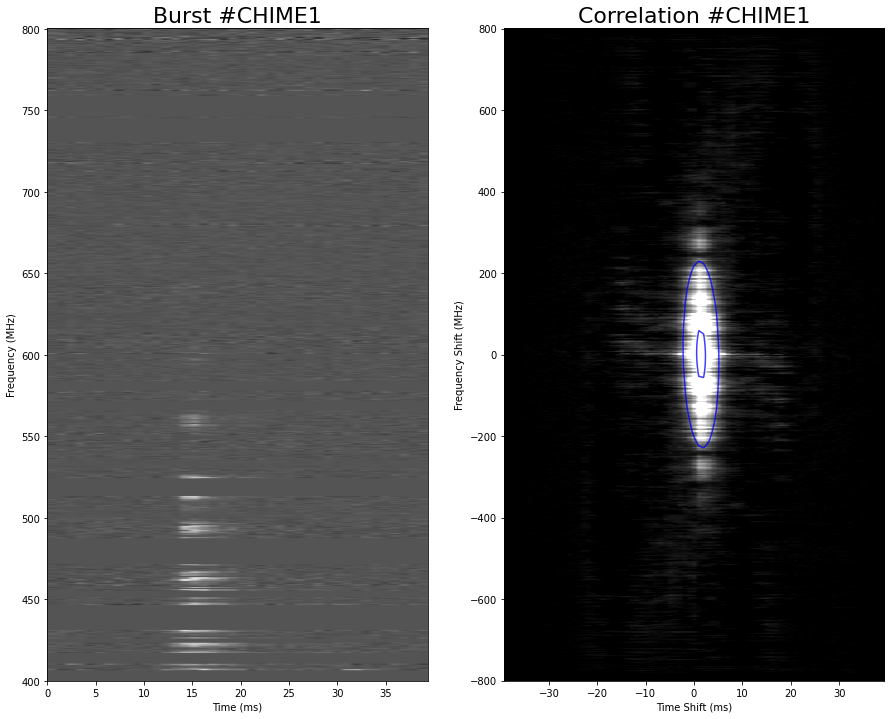

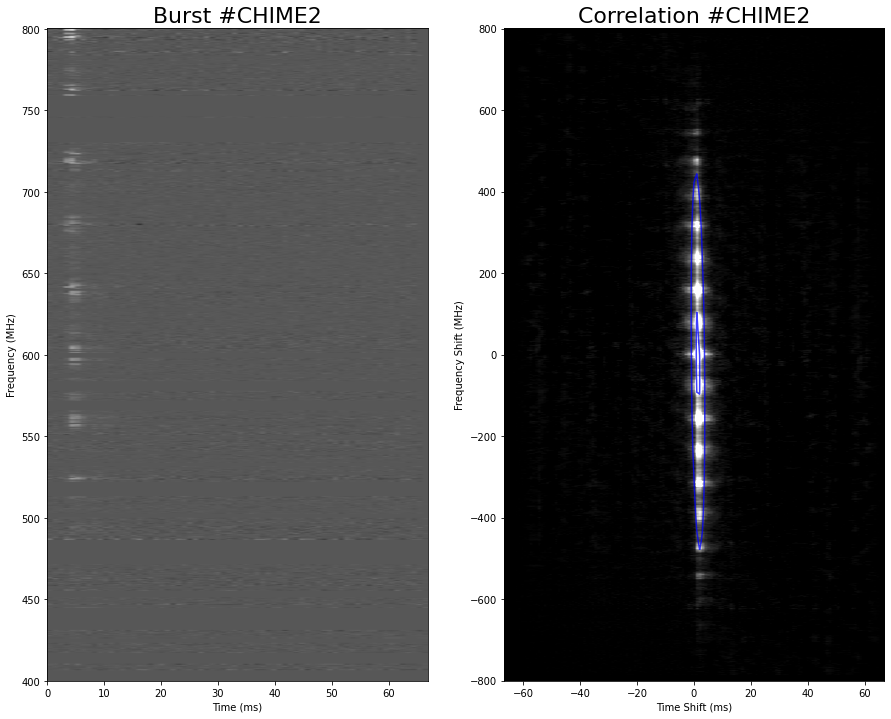

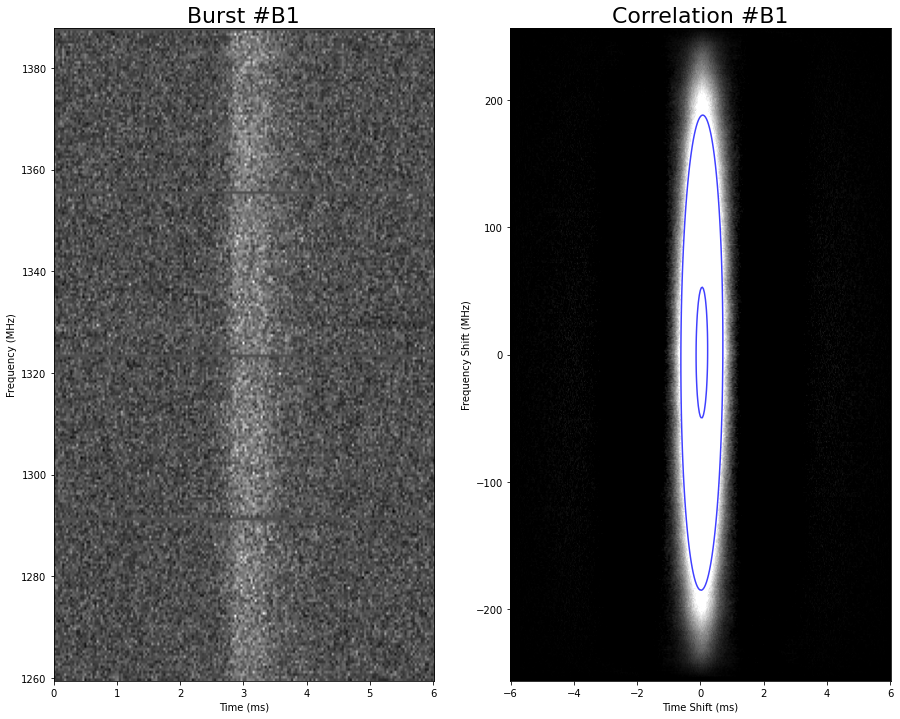

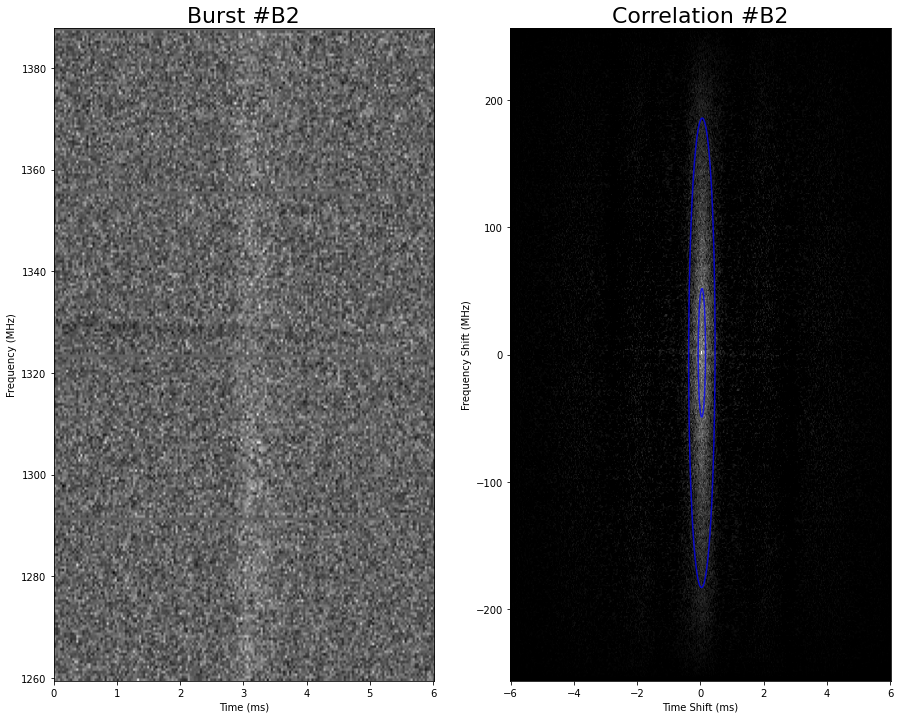

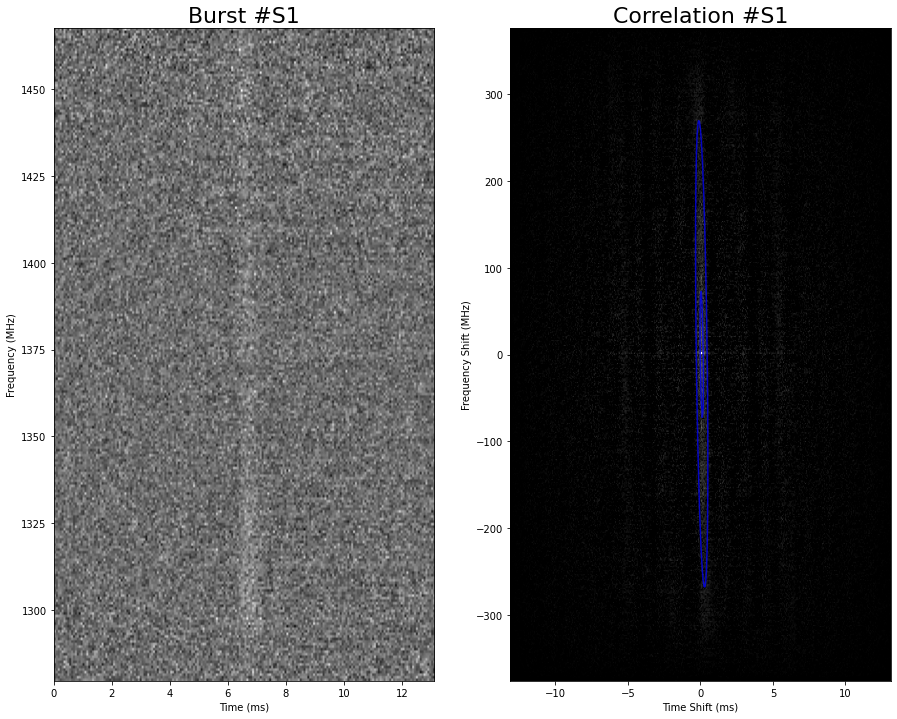

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import driftrate

cmap = 'gray'
def getCHIMEBurst(plot=False):
    maxsnr_beam = 2067
    #data = np.load("data/chime/aro_detection.npz")
    data = np.load("data/chime/chimefrb_SGR1935+2154_20200428_B{}.npz".format(maxsnr_beam))
    #print(data.files)
    intensity = data["intensity"]
    intensity = np.nan_to_num(intensity)
    
    #corr = driftrate.auto_corr2D_viafft(intensity[:,50:90])
    if plot:
        plt.figure(figsize=(15,9))
        plt.imshow(intensity[:, 40:], aspect="auto", origin="lower", cmap=cmap)
        plt.clim(-0.15, 0.1)
        print(np.min(intensity), np.max(intensity))
    
    # CHIME
    burst1 = intensity[:, 50:90]
    burst2 = intensity[:, 90:]
    
    # ARO
    #burst1 = intensity[:, 40:70]
    #burst2 = intensity[:, 71:90]
    
    return [burst1, burst2]

def getKirstenBursts(plot=False):
    kirstenb1 = np.load('data/franz/kirsten_et_al_NatAst_2020/burst_plot/B1_downsampled.npy')
    kirstenb2 = np.load('data/franz/kirsten_et_al_NatAst_2020/burst_plot/B2_downsampled.npy')

    # noise
    for chan in [191, 127, 63]:
        kirstenb1[chan:chan+1] = 0
        kirstenb2[chan:chan+1] = 0

    if plot:
        for burst in [kirstenb1, kirstenb2]:
            plt.figure(figsize=(8,15))
            plt.imshow(burst, aspect="auto", origin="lower", cmap=cmap)
            plt.clim(-1,1)

    return [kirstenb1, kirstenb2]

stare2_subband = 6
def getSTARE2Burst(plot=False):
    stareburst = np.load('data/stare2/ovro_dedisp_dm332.702.npy')
    stareburst[0:500,...] = 0
    stareburst[2036:,...] = 0
    stareburst = stareburst[500:2036]
    
    stareburst = stareburst[:,400:600]
    stareburst = stareburst - stareburst[:, 0:75].mean(axis=1)[:, None]
    stareburst = driftrate.subband(stareburst, 1536//stare2_subband)
    stareburst = np.flipud(stareburst)

    return [stareburst]

AROParameters = {
    'dt_s'            : 0.00098304,
    'df_mhz'          : 400/256,
    'nchan'           : 1024,
    'freq_bottom_mhz' : 400.1953125,
    'freq_top_mhz'    : 800.1953125
}

CHIMEParameters = {
    'dt_s'            : 0.00098304,
    'df_mhz'          : 400/1024,
    'nchan'           : 1024,
    'freq_bottom_mhz' : 400.1953125,
    'freq_top_mhz'    : 800.1953125
}

KirstenParameters = {
    'dt_s'            : 32*10**-6,
    'df_mhz'          : 0.5,
    'nchan'           : 256,
    'freq_bottom_mhz' : 1259.74, 
    'freq_top_mhz'    : 1387.74
}

STARE2Parameters = {
    'dt_s'            : 0.000065536,
    'df_mhz'          : (1530-1280)/2048*stare2_subband, # ~0.12MHz
    'nchan'           : 2048,
    'freq_bottom_mhz' : 1280, 
    'freq_top_mhz'    : 1530
}

bursts = getCHIMEBurst() + getKirstenBursts() + getSTARE2Burst()

# CHIME1 Masking
bursts[0][221:224] = 0
bursts[0][257:259] = 0
bursts[0][312:318] = 0
bursts[0][144:146] = 0
bursts[0][114:116] = 0

# CHIME2 Masking
bursts[1][144:146] = 0
bursts[1][220:222] = 0
bursts[1][256:260] = 0
bursts[1][309:313] = 0
bursts[1][476:480] = 0
bursts[1][511:514] = 0
bursts[1][969:971] = 0
bursts[1][1006:1008] = 0

outputdata = pd.DataFrame(index=['CHIME1', 'CHIME2', 'B1', 'B2', 'S1'], 
                          columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta', 'amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error',
                                  'drift (mhz/ms)', 'drift error (mhz/ms)', 'angle', 'center_f', 'red_chisq', 'time_res', 'freq_res'])
for burst, bid, p0 in zip(bursts, 
                          ['CHIME1', 'CHIME2', 'B1', 'B2', 'S1'], 
                          [[1000, 40, 1024, 50, 10, 1.567], [41, 68, 1023, 176, 2, 1.57], [], [], []]):

    if bid[0] == 'C':
        params = CHIMEParameters
    elif bid[0] == 'A':
        params = AROParameters
    elif bid[0] == 'B':
        params = KirstenParameters
    elif bid[0] == 'S':
        params = STARE2Parameters

    if bid[0] != 'S': # dedisperse to the STARE2 DM
        ddm = 332.702 - 332.7206
        print('dedispersing {} by {} pc/cm^3'.format(bid, ddm))
        burst = driftrate.dedisperse(burst, ddm, params['freq_bottom_mhz'], params['df_mhz'], params['dt_s']*1000)
    
    drift, drift_error, popt, perr, theta, red_chisq, center_f = driftrate.processBurst(burst, bid, params['df_mhz'], params['dt_s']*1000, params['freq_bottom_mhz'], p0=p0)
    outputdata.loc[bid] = [*popt, *perr, drift, drift_error, theta, center_f, red_chisq, params['dt_s'], params['df_mhz']]
    plt.savefig('figures/{}corr.png'.format(bid))

outfile = 'SGR1953+2154bursts.csv'
outputdata.to_csv(outfile, index_label="name")

from shutil import copyfile
copyfile(outfile, '../sadtrombone/universal/data/SGR1935+2154/{}'.format(outfile))
outputdata